In [2]:
%matplotlib inline
import os,random,sys
import numpy as np

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
device = torch.device("cuda") 

import matplotlib.pyplot as plt
import time
from glob import glob

# In Python 2, cPickle is the accelerated version of pickle, and a later addition to thestandard library.
# It was perfectly normal to import it with a fallback to pickle. In Python 3 the accelerated version has been integrated
# and there is simply no reason to use anything other than import pickle
import pickle

from google.colab import drive
drive.mount('/content/drive')
root = "/content/drive/My Drive/Deep Learning course 2020/Proj/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


# Dataset setup

In [3]:
#FFT games
def IQ2Complex(iqArray):
  return iqArray[:,0,:] + 1j*iqArray[:,1,:]
def Complex2IQ(complexArray):
  I = np.real(complexArray)
  Q = np.imag(complexArray)
  return np.concatenate((I[:,np.newaxis,:], Q[:,np.newaxis,:]), axis=1)

# Load the dataset ...
Xd = pickle.load(open(root + "2016.04C.multisnr.pkl",'rb'), encoding="latin1")
#Xd = pickle.load(open(root + "RML2016.10a_dict.pkl",'rb'), encoding="latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
XComplex = IQ2Complex(X)
fftXComplex = np.fft.fft(XComplex)
fftX_IQ = np.array(Complex2IQ(fftXComplex), dtype=np.float32)
print(X.shape)
print(fftX_IQ.shape)
print(X.dtype)
print(fftX_IQ.dtype)
# X: (N, 2, 128). for each of the N=220,000 examples, there is a 128-long measurement of I/Q samples.
# mods: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
# lbl: list of tuples, each of the pattern ('GFSK', -20) 

(162060, 2, 128)
(162060, 2, 128)
float32
float32


In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

np.random.seed(203142260 + 305773673)
n_examples = X.shape[0]  # 220,000 C:162060
n_train = int(n_examples * 0.6)  # 110,000 C:97236
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_FFT_train = fftX_IQ[train_idx]
X_test =  X[test_idx]
X_FFT_test = fftX_IQ[test_idx]


Y_train = np.array(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = np.array(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

print(f'examples: {n_examples}, train={n_train}, test={len(X_test)}')
print(X_FFT_train.shape)
print(X_train.shape)


examples: 162060, train=97236, test=64824
(97236, 2, 128)
(97236, 2, 128)


# Build the NN Model

In [6]:
#Pytorch
dr = 0.5 # dropout rate (%)
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.convPart = nn.Sequential(
            # input is batch x 1 x 2 x 128
            # (Reshape([1]+in_shp, input_shape=in_shp))  #  - Reshape [N,2,128] to [N,1,2,128] on input
            nn.Conv2d(1, 256, kernel_size=(1, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256 x 2 x 130
            nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2, 3), padding=(0, 2)),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 80 x 1 x 132
        )
        
        self.firstLinearSize = 80 * 132
        self.linPart = nn.Sequential(
            nn.Linear(self.firstLinearSize, 256),
            nn.ReLU(True),
            nn.Dropout(dr),
            # state size. batch x 256
            nn.Linear(256, len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.convPart(input)
        out = out.view(-1, self.firstLinearSize)
        out = self.linPart(out)
        #out = F.softmax(out, dim=1)
        return out

class CNN2_Ensamble(nn.Module):
    def __init__(self, withFFTdata = False):
        super(CNN2_Ensamble, self).__init__()
        self.modelTimeSamples = CNN2()
        self.modelFFTSamples = CNN2()
        self.linPart = nn.Sequential(
            nn.Linear(2*len(mods), len(mods)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        out = self.modelTimeSamples(input[:,0])
        outFFT = self.modelFFTSamples(input[:,1]) 
        out = torch.cat((out, outFFT), 1)
        out = out.view(-1, 2*len(mods))
        out = self.linPart(out)
        #out = F.softmax(out, dim=1)
        return out

# custom weights initialization #  to mean=0, stdev=0.2.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and the Discriminator
withFFTdata = True
net =  CNN2().to(device)
if withFFTdata:
  net =  CNN2_Ensamble().to(device)
# Apply the weights_init function to randomly initialize all weights
net.apply(weights_init)

# Print the model                                    
print(net)

# model.add(Reshape([len(classes)]))
# model.compile(loss='categorical_crossentropy', optimizer='adam')
if withFFTdata:
  summary(net, (2, 1, 2, 128))
else:
  summary(net, (1, 2, 128))

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
# Setup Adam optimizers for both G and D
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, beta2))

CNN2_Ensamble(
  (modelTimeSamples): CNN2(
    (convPart): Sequential(
      (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
    )
    (linPart): Sequential(
      (0): Linear(in_features=10560, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=11, bias=True)
      (4): LogSoftmax(dim=1)
    )
  )
  (modelFFTSamples): CNN2(
    (convPart): Sequential(
      (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
    )
  

# Train the Model

In [7]:
# Set up some params 
if withFFTdata:
  X_train = np.concatenate((X_train[:, np.newaxis, :, :], X_FFT_train[:, np.newaxis, :, :]), axis=1)
  X_test = np.concatenate((X_test[:, np.newaxis, :, :], X_FFT_test[:, np.newaxis, :, :]), axis=1)
print(X_train.shape)
print(X_test.shape)
num_epochs = 100    #  Noam - they did 100
batch_size = 1024  # training batch size.  Noam - they did 1024
num_batches = len(X_train) // batch_size
epoch_size = batch_size * num_batches

(97236, 2, 2, 128)
(64824, 2, 2, 128)


In [8]:
def prepare_data_into_batches(data, labels, permute, withFFTdata = False):
  # Prepare data
  if permute is True:
    perm = torch.randperm(len(data))  # Shuffles along the first axis. shape = (110000, 2, 128) just like X_train
  else:
    perm = np.arange(len(data))

  n_batches = len(data) // batch_size
  tot_size = n_batches * batch_size
  
  shuffled = data[perm]
  shuffled = shuffled[:tot_size]        # Cutting off the last part that is smaller than one batch.  shape = (tot_size, 2, 128) just like X_train
  if withFFTdata:
    prepared = shuffled.reshape(n_batches, -1, 2, 2, 128)  # Get into a shape that each element is a batch. shape = (107, batch_size, 2, 2, 128)
    prepared = np.expand_dims(prepared, axis=3)           # Add a space for num_channels (it's 1 in our case). shape = (107, batch_size, 1, 2, 128)
  else:
    prepared = shuffled.reshape(n_batches, -1, 2, 128)  # Get into a shape that each element is a batch. shape = (107, batch_size, 2, 128)
    prepared = np.expand_dims(prepared, axis=2)           # Add a space for num_channels (it's 1 in our case). shape = (107, batch_size, 1, 2, 128)

  labels = labels[perm]
  labels = labels[:tot_size]
  labels = labels.reshape(n_batches, -1)
  return prepared, labels
  
def get_batch_results(batch):
  batchData = torch.from_numpy(batch[0]).to(device)
  batchLabels = torch.from_numpy(batch[1]).to(device)
  
  output = net(batchData)
  _, pred = torch.max(output.detach(), dim=1)
  correct = torch.sum(pred.eq(batchLabels)).cpu().numpy()

  return output, batchLabels, correct

  
def save_network(epoch):
  path = f'{root}saved models/epoch {epoch+1}.pt'
  torch.save(netD.state_dict(), path)

In [108]:
  trainData, trainLables = prepare_data_into_batches(X_train, Y_train, permute=True, withFFTdata=withFFTdata)
  print(trainData.shape)

(94, 1024, 2, 1, 2, 128)


In [9]:
trainLoss = np.zeros(num_epochs)
testLoss = np.zeros(num_epochs)

startEpoch = 0
loadPath = f'{root}saved models/epoch {100}.pt'
filename = glob(loadPath)[0]
#net.load_state_dict(torch.load(filename))

for epoch in range(num_epochs):
  totEpoch = epoch + startEpoch
  print(f'epoch: {totEpoch + 1}/{num_epochs + startEpoch}, ', end='')
  start = time.time()

  trainData, trainLables = prepare_data_into_batches(X_train, Y_train, permute=True, withFFTdata=withFFTdata)
  testData, testLables = prepare_data_into_batches(X_test, Y_test, permute=True, withFFTdata=withFFTdata)
  
  net.train()
  correctTrain = 0
  trainEpochloss = 0
  for i, batch in enumerate(zip(trainData, trainLables)):
    net.zero_grad()

    output, batchLabels, correct = get_batch_results(batch)
    loss = criterion(output, batchLabels)
    loss.backward()
    optimizer.step()

    correctTrain += correct
    trainEpochloss += loss

  net.eval()
  correctTest = 0
  testEpochloss = 0
  with torch.no_grad():
    for i, batch in enumerate(zip(testData, testLables)):
      output, batchLabels, correct = get_batch_results(batch)
      correctTest += correct
      testEpochloss += criterion(output, batchLabels)

  trainAcc = correctTrain / epoch_size * 100
  testAcc = correctTest / epoch_size * 100
  trainLoss[epoch] = trainEpochloss / num_batches
  testLoss[epoch] = testEpochloss / num_batches
  print(f'train loss: {trainLoss[epoch]:.2f}, test loss: {testLoss[epoch]:.2f}, train accuracy: {trainAcc:.2f}%, test accuracy: {testAcc:.2f}%, elapsed time: {time.time() - start:.0f}s')
  torch.save(net.state_dict(), f'{root}saved models/epoch {totEpoch+1}.pt')

epoch: 1/100, train loss: 2.32, test loss: 1.51, train accuracy: 15.29%, test accuracy: 13.93%, elapsed time: 26s
epoch: 2/100, train loss: 1.93, test loss: 0.95, train accuracy: 31.31%, test accuracy: 30.89%, elapsed time: 26s
epoch: 3/100, train loss: 1.36, test loss: 0.84, train accuracy: 49.01%, test accuracy: 35.84%, elapsed time: 26s
epoch: 4/100, train loss: 1.26, test loss: 0.78, train accuracy: 53.59%, test accuracy: 38.41%, elapsed time: 26s
epoch: 5/100, train loss: 1.19, test loss: 0.75, train accuracy: 55.94%, test accuracy: 39.07%, elapsed time: 26s
epoch: 6/100, train loss: 1.15, test loss: 0.73, train accuracy: 57.45%, test accuracy: 39.67%, elapsed time: 26s
epoch: 7/100, train loss: 1.11, test loss: 0.70, train accuracy: 58.53%, test accuracy: 40.46%, elapsed time: 26s
epoch: 8/100, train loss: 1.09, test loss: 0.69, train accuracy: 59.52%, test accuracy: 41.04%, elapsed time: 26s
epoch: 9/100, train loss: 1.07, test loss: 0.69, train accuracy: 60.05%, test accuracy: 

# Evaluate and Plot Model Performance

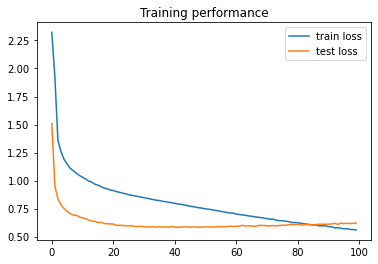

In [10]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(trainLoss, label='train loss')  # NOAM -  they had train loss + error - what does this mean?
plt.plot(testLoss, label='test loss')  # NOAM -  they had val_error is that different than the loss?
plt.legend()

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def get_conf_from_batch(out, labels):
  batch_conf = np.zeros([len(mods),len(mods)], dtype=int)
  for i in range(len(labels)):
    j = labels[i]              # true label
    k = int(np.argmax(out[i]))   # predicted label
    batch_conf[j,k] += 1
  return batch_conf


def prepare_batches(snr):
    snrIndices = np.argwhere(test_SNRs==snr)
    batches_per_snr = len(snrIndices) // batch_size
    last_batch_size = np.remainder(len(snrIndices), batch_size)
    
    snr_x = X_test[snrIndices]
    snr_y = Y_test[snrIndices]    

    signals, lables = prepare_data_into_batches(snr_x, snr_y, permute=False, withFFTdata=withFFTdata)
    
    x_last_batch = snr_x[-last_batch_size:]
    y_last_batch = snr_y[-last_batch_size:]
    print(x_last_batch.shape)
    if withFFTdata:
      x_last_batch = x_last_batch.reshape(-1, 2, 2, 128)  
      x_last_batch = np.expand_dims(x_last_batch, axis=2) 
    else:
      x_last_batch = x_last_batch.reshape(-1, 2, 128)  
      x_last_batch = np.expand_dims(x_last_batch, axis=1)          
    print(x_last_batch.shape)       
    # y_last_batch = y_last_batch.reshape(-1)
    
    return signals, lables, x_last_batch, y_last_batch


SNR = -20dB: (161, 1, 2, 2, 128)
(161, 2, 1, 2, 128)
Overall Accuracy: 10.2%
SNR = -18dB: (206, 1, 2, 2, 128)
(206, 2, 1, 2, 128)
Overall Accuracy: 10.0%
SNR = -16dB: (139, 1, 2, 2, 128)
(139, 2, 1, 2, 128)
Overall Accuracy: 10.5%
SNR = -14dB: (232, 1, 2, 2, 128)
(232, 2, 1, 2, 128)
Overall Accuracy: 12.8%
SNR = -12dB: (213, 1, 2, 2, 128)
(213, 2, 1, 2, 128)
Overall Accuracy: 24.0%
SNR = -10dB: (110, 1, 2, 2, 128)
(110, 2, 1, 2, 128)
Overall Accuracy: 36.6%
SNR = -8dB: (123, 1, 2, 2, 128)
(123, 2, 1, 2, 128)
Overall Accuracy: 58.0%
SNR = -6dB: (237, 1, 2, 2, 128)
(237, 2, 1, 2, 128)
Overall Accuracy: 71.0%
SNR = -4dB: (188, 1, 2, 2, 128)
(188, 2, 1, 2, 128)
Overall Accuracy: 80.7%
SNR = -2dB: (45, 1, 2, 2, 128)
(45, 2, 1, 2, 128)
Overall Accuracy: 90.2%
SNR = 0dB: (159, 1, 2, 2, 128)
(159, 2, 1, 2, 128)
Overall Accuracy: 90.8%
SNR = 2dB: (224, 1, 2, 2, 128)
(224, 2, 1, 2, 128)
Overall Accuracy: 92.7%
SNR = 4dB: (149, 1, 2, 2, 128)
(149, 2, 1, 2, 128)
Overall Accuracy: 95.2%
SNR = 6dB: 

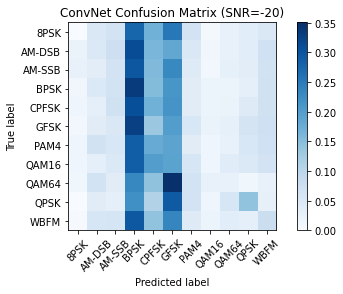

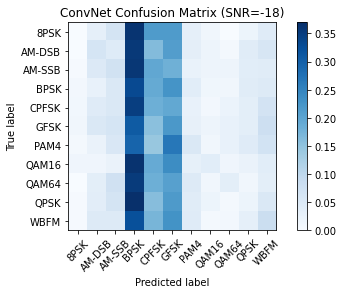

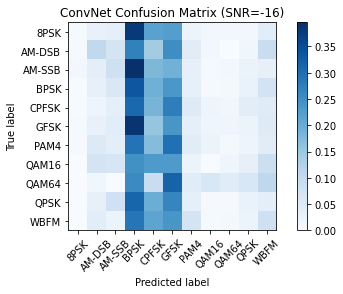

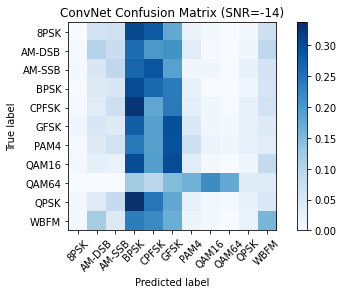

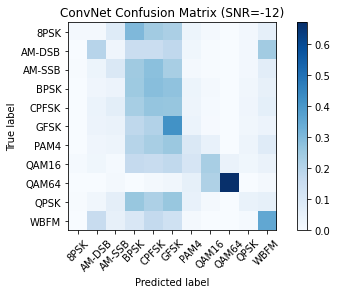

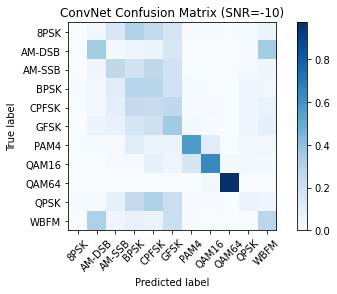

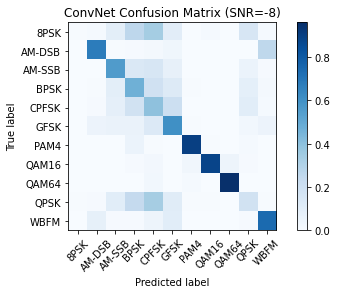

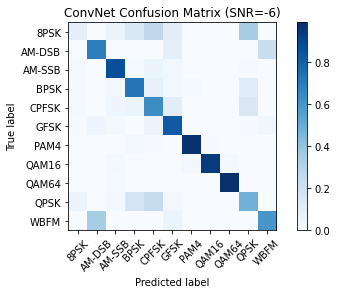

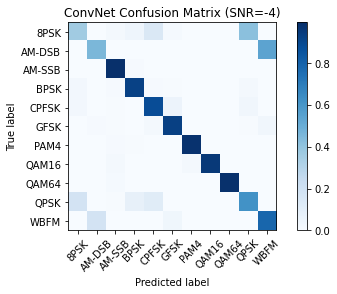

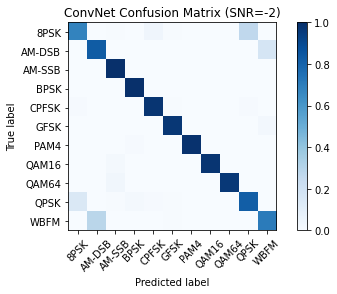

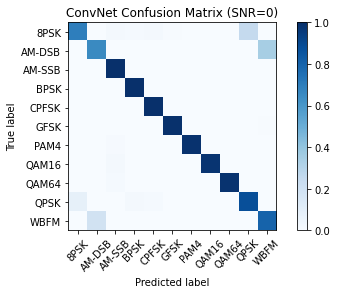

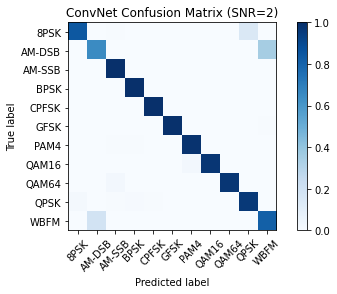

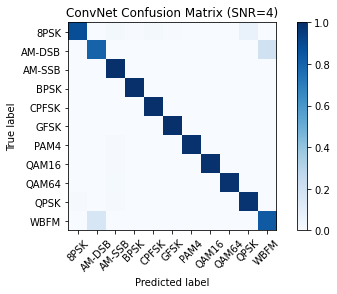

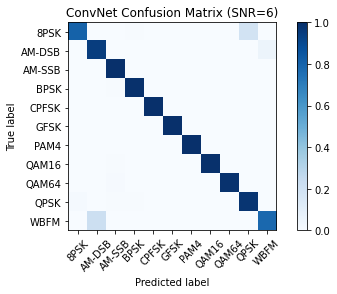

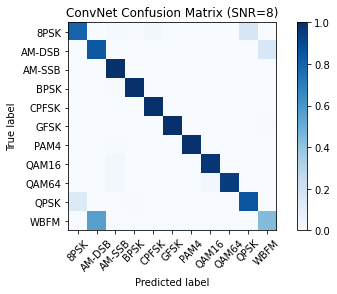

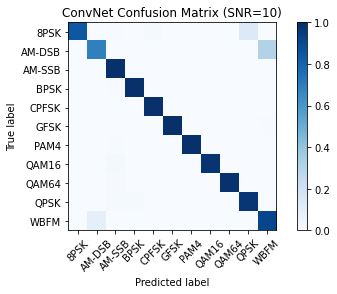

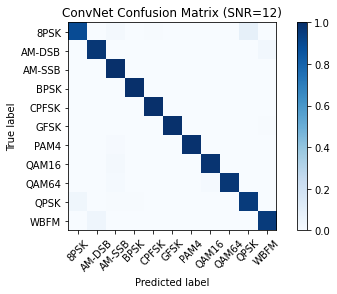

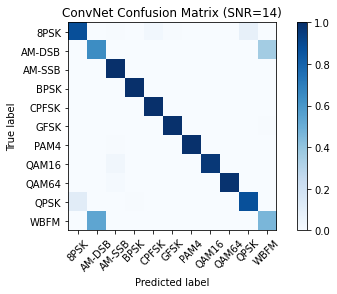

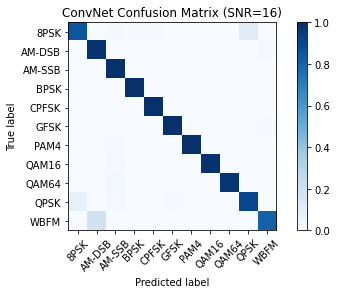

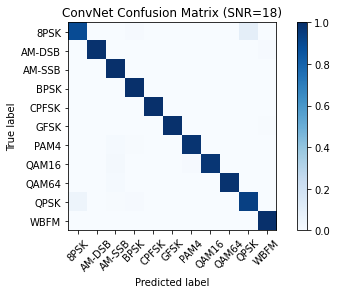

In [19]:
# 20 snrs, 100 batches per epoch - 5 batches per snr. but same amount of samples per snr isn't constant  (close: std ~ 41)
acc = {}
net.eval()
test_SNRs = np.array(list(map(lambda x: lbl[x][1], test_idx)))
for snr in snrs:
  print(f'SNR = {snr}dB: ', end='')

  conf = np.zeros([len(mods),len(mods)], dtype=int)
  confnorm = np.zeros([len(mods),len(mods)], dtype=float)
  signals, lables, x_last_batch, y_last_batch = prepare_batches(snr)

  for batch in zip(signals, lables):
    output, batchLabels,_ = get_batch_results(batch)
    conf += get_conf_from_batch(output.detach().cpu().numpy(), batchLabels)
  # last partial batch
  output, batchLabels,_ = get_batch_results((x_last_batch, y_last_batch))
  conf += get_conf_from_batch(output.detach().cpu().numpy(), batchLabels)

  for i in range(len(mods)):
    row_sum = np.sum(conf[i,:])
    if row_sum != 0:
      confnorm[i,:] = conf[i,:] / row_sum

  plt.figure()
  plot_confusion_matrix(confnorm, labels=mods, title=f'ConvNet Confusion Matrix (SNR={snr})')
  cor = np.sum(np.diag(confnorm))
  ncor = np.sum(confnorm) - cor
  acc[snr] = cor/(cor+ncor) * 100
  print (f'Overall Accuracy: {acc[snr]:.1f}%')
  

Text(0.5, 0.98, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

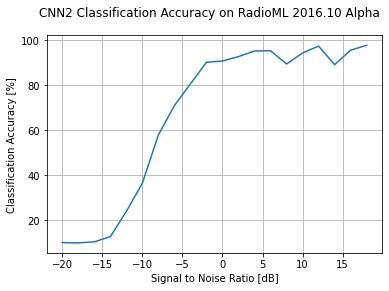

In [21]:
# Plot accuracy curve
plt.figure()
plt.grid()
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio [dB]")
plt.ylabel("Classification Accuracy [%]")
plt.suptitle('CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

In [ ]:
# Save results to a pickle file for plotting later
fd = open(root + 'results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

<All keys matched successfully>